# Exercise Sheet 5: OpenMPI

```
Lecture Parallel Computing Systems, Winter semester 2025/2026
Prof. Dr.-Ing. Mladen Berekovic
A discussion forum for the exercise can be found at: moodle.uni-luebeck.de.
```

This exercise introduces Message Passing Interface (MPI) parallelization in C/C++ using explicit communication calls to coordinate work across multiple processes. Students learn to initialize and finalize MPI programs, distribute data and computation with point-to-point and collective operations (e.g., `MPI_Send`, `MPI_Recv`, `MPI_Bcast`, `MPI_Reduce`), and reason about synchronization and communication overhead. Using OpenMPI as the runtime implementation, they will compile and launch multi-process applications across cores and (optionally) multiple nodes, then analyze scalability and performance trade-offs on distributed-memory systems.

Because the free tier of Google Colab offers only 2 CPU cores, the students should focus on the programming model, coding and correctness verification rather than speeding it up.

## Submission Guidelines

Please follow the instructions in the Submission Guidelines document published within this course.

## Task 1: Hello World

This task helps students to understand some basic syntax of OpenMPI programming in C/C++. Completing the task to please these requirements:
1. Query the number of threads of the system
2. Print out "Hello World" on different threads. For example: "Hello World from thread 0 of 2".

In [1]:
%%writefile ompi_helloworld.c
#include <mpi.h>
#include <stdio.h>

int main(int argc, char **argv) {
    int rank, size;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);
    printf("Hello World from thread %d of %d\n", rank, size);
    MPI_Finalize();
    return 0;
}

Writing ompi_helloworld.c


### Open MPI: --oversubscribe

Allows launching more MPI processes (ranks) than the runtime thinks there are  available slots / CPU cores on the node. This is useful for testing or for environments that report too few cores, but it typically reduces performance because multiple ranks time-share the same cores (more context switching and cache contention). Open MPI may also switch to a degraded progress mode when it detects oversubscription so that ranks yield CPU time more often.

In [2]:
!mpicc ompi_helloworld.c -o ompi_helloworld
!mpirun --allow-run-as-root --oversubscribe -np 2 ompi_helloworld

Hello World from thread 0 of 2
Hello World from thread 1 of 2


In [3]:
!mpirun --allow-run-as-root --oversubscribe -np 4 ompi_helloworld

Hello World from thread 2 of 4
Hello World from thread 1 of 4
Hello World from thread 0 of 4
Hello World from thread 3 of 4


## Task 2: Pairwise Communication

Develop an MPI program that measures the transit times between two MPI participants with a ping pong. For this, the master should send a message (Ping) and receive the content of the same in a reply (Pong).

_Note: With the command MPI_Wtime() you can read out the current system time._

Complete the task to meet these requirements:

1. The program can send and receive messages.
2. The program can measure the transit times between two MPI participants.
3. Sweep the message size and report both latency and effective bandwidth in a graph.


In [4]:
%%writefile ompi_pingpong.c
#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#define ITERS 1000

int main(int argc, char **argv) {
    int rank, nprocs;
    MPI_Status st;
    int sizes[] = {1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 4096, 16384, 65536, 262144};
    int nsizes = sizeof(sizes)/sizeof(sizes[0]);

    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    if (nprocs != 2) {
        if (rank == 0) printf("Need exactly 2 processes\n");
        MPI_Finalize();
        return 1;
    }

    if (rank == 0) printf("MsgSize(bytes),Latency(us),Bandwidth(MB/s)\n");

    for (int i = 0; i < nsizes; i++) {
        int sz = sizes[i];
        char *buf = malloc(sz);
        memset(buf, 'x', sz);

        MPI_Barrier(MPI_COMM_WORLD);
        double t0 = MPI_Wtime();

        for (int j = 0; j < ITERS; j++) {
            if (rank == 0) {
                MPI_Send(buf, sz, MPI_CHAR, 1, 0, MPI_COMM_WORLD);
                MPI_Recv(buf, sz, MPI_CHAR, 1, 0, MPI_COMM_WORLD, &st);
            } else {
                MPI_Recv(buf, sz, MPI_CHAR, 0, 0, MPI_COMM_WORLD, &st);
                MPI_Send(buf, sz, MPI_CHAR, 0, 0, MPI_COMM_WORLD);
            }
        }

        double elapsed = MPI_Wtime() - t0;
        if (rank == 0) {
            double lat = (elapsed / (2 * ITERS)) * 1e6;
            double bw = (2.0 * sz * ITERS) / (elapsed * 1e6);
            printf("%d,%.3f,%.3f\n", sz, lat, bw);
        }
        free(buf);
    }

    MPI_Finalize();
    return 0;
}

Writing ompi_pingpong.c


In [5]:
!mpicc ompi_pingpong.c -o ompi_pingpong
!mpirun --allow-run-as-root --oversubscribe -np 2 ompi_pingpong > pingpong_results.csv
!cat pingpong_results.csv

MsgSize(bytes),Latency(us),Bandwidth(MB/s)
1,0.498,2.008
2,0.527,3.792
4,0.522,7.663
8,0.491,16.294
16,0.509,31.446
32,0.500,64.037
64,0.486,131.805
128,0.497,257.469
256,0.481,532.299
512,0.645,793.912
1024,0.677,1511.774
4096,2.472,1657.128
16384,3.327,4924.352
65536,7.242,9049.886
262144,44.635,5873.086


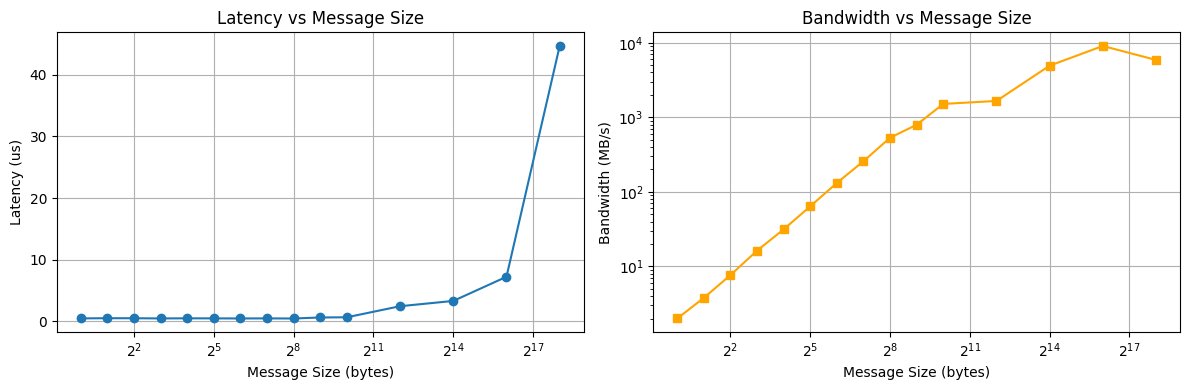

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('pingpong_results.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(df['MsgSize(bytes)'], df['Latency(us)'], 'o-')
ax1.set_xscale('log', base=2)
ax1.set_xlabel('Message Size (bytes)')
ax1.set_ylabel('Latency (us)')
ax1.set_title('Latency vs Message Size')
ax1.grid(True)

ax2.plot(df['MsgSize(bytes)'], df['Bandwidth(MB/s)'], 's-', color='orange')
ax2.set_xscale('log', base=2)
ax2.set_yscale('log')
ax2.set_xlabel('Message Size (bytes)')
ax2.set_ylabel('Bandwidth (MB/s)')
ax2.set_title('Bandwidth vs Message Size')
ax2.grid(True)

plt.tight_layout()
plt.savefig('pingpong_analysis.png', dpi=150)
plt.show()

## Task 3: Collective Communication

Develop an MPI program that performs 2 Collective Communication: One-to-All and All-to-One. Our problem is sorting the characters in a huge text file.

Complete the task to meet these requirements:

1. Read the text file and load it into dynamically reallocated memory before starting any processing.

2. The root process must partition and distribute the workload to the other processes, and also participate in the sorting itself.

3. After finishing their assigned work, all processes must send their results back to the root process.

4. Evaluate performance using a very large input text file sized to utilize most or all available system RAM, run with varying numbers of processes/threads, and present the resulting speedup in a graph.

In [7]:
import os, string

def write_random_ascii(path, size_bytes, chunk=1<<20):
    alphabet = string.printable.encode('ascii')
    m = len(alphabet)
    with open(path, 'wb') as f:
        rem = size_bytes
        while rem:
            n = min(chunk, rem)
            rnd = os.urandom(n)
            f.write(bytes(alphabet[b % m] for b in rnd))
            rem -= n

write_random_ascii('database.txt', 100 * 1024**2)
print(f"Created: {os.path.getsize('database.txt') / 1024**2:.1f} MB")

Created: 100.0 MB


In [8]:
%%writefile ompi_colcomm.c
#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

int cmp(const void *a, const void *b) { return *(char*)a - *(char*)b; }

void merge(char *a, int na, char *b, int nb, char *out) {
    int i=0, j=0, k=0;
    while (i < na && j < nb) out[k++] = (a[i] <= b[j]) ? a[i++] : b[j++];
    while (i < na) out[k++] = a[i++];
    while (j < nb) out[k++] = b[j++];
}

int main(int argc, char **argv) {
    int rank, nprocs;
    char *data = NULL;
    long fsize = 0;

    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    if (rank == 0) {
        FILE *fp = fopen("database.txt", "rb");
        if (!fp) { MPI_Abort(MPI_COMM_WORLD, 1); }
        fseek(fp, 0, SEEK_END);
        fsize = ftell(fp);
        fseek(fp, 0, SEEK_SET);
        data = malloc(fsize);
        fread(data, 1, fsize, fp);
        fclose(fp);
    }

    MPI_Bcast(&fsize, 1, MPI_LONG, 0, MPI_COMM_WORLD);

    int *scnt = malloc(nprocs * sizeof(int));
    int *disp = malloc(nprocs * sizeof(int));
    int base = fsize / nprocs, rem = fsize % nprocs, off = 0;
    for (int i = 0; i < nprocs; i++) {
        scnt[i] = base + (i < rem ? 1 : 0);
        disp[i] = off;
        off += scnt[i];
    }

    int mylen = scnt[rank];
    char *local = malloc(mylen);

    MPI_Barrier(MPI_COMM_WORLD);
    double t0 = MPI_Wtime();

    MPI_Scatterv(data, scnt, disp, MPI_CHAR, local, mylen, MPI_CHAR, 0, MPI_COMM_WORLD);
    qsort(local, mylen, 1, cmp);

    char *gathered = NULL;
    if (rank == 0) gathered = malloc(fsize);
    MPI_Gatherv(local, mylen, MPI_CHAR, gathered, scnt, disp, MPI_CHAR, 0, MPI_COMM_WORLD);

    if (rank == 0) {
        char *sorted = malloc(fsize);
        char *tmp = malloc(fsize);
        memcpy(sorted, gathered, scnt[0]);
        int len = scnt[0];
        for (int i = 1; i < nprocs; i++) {
            merge(sorted, len, gathered + disp[i], scnt[i], tmp);
            len += scnt[i];
            memcpy(sorted, tmp, len);
        }
        double elapsed = MPI_Wtime() - t0;
        printf("%d,%.4f\n", nprocs, elapsed);
        free(sorted); free(tmp); free(gathered); free(data);
    }

    free(local); free(scnt); free(disp);
    MPI_Finalize();
    return 0;
}

Writing ompi_colcomm.c


In [9]:
!mpicc ompi_colcomm.c -o ompi_colcomm
!echo "nprocs,time"
!mpirun --allow-run-as-root --oversubscribe -np 1 ompi_colcomm
!mpirun --allow-run-as-root --oversubscribe -np 2 ompi_colcomm
!mpirun --allow-run-as-root --oversubscribe -np 4 ompi_colcomm
!mpirun --allow-run-as-root --oversubscribe -np 8 ompi_colcomm

nprocs,time
1,25.0826
2,22.5362
4,22.2383
8,23.0099


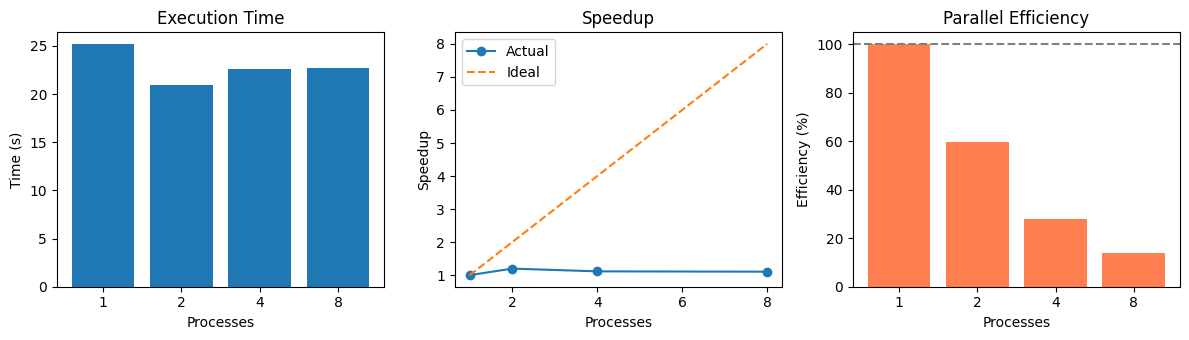

In [10]:
import subprocess, re
import matplotlib.pyplot as plt

procs = [1, 2, 4, 8]
times = []

for p in procs:
    res = subprocess.run(['mpirun', '--allow-run-as-root', '--oversubscribe', '-np', str(p), './ompi_colcomm'],
                         capture_output=True, text=True)
    m = re.search(r',(\d+\.\d+)', res.stdout)
    times.append(float(m.group(1)) if m else float('nan'))

t1 = times[0]
speedup = [t1/t for t in times]
eff = [s/p*100 for s,p in zip(speedup, procs)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5))

ax1.bar(range(len(procs)), times)
ax1.set_xticks(range(len(procs))); ax1.set_xticklabels(procs)
ax1.set_xlabel('Processes'); ax1.set_ylabel('Time (s)')
ax1.set_title('Execution Time')

ax2.plot(procs, speedup, 'o-', label='Actual')
ax2.plot(procs, procs, '--', label='Ideal')
ax2.set_xlabel('Processes'); ax2.set_ylabel('Speedup')
ax2.set_title('Speedup'); ax2.legend()

ax3.bar(range(len(procs)), eff, color='coral')
ax3.axhline(100, ls='--', color='gray')
ax3.set_xticks(range(len(procs))); ax3.set_xticklabels(procs)
ax3.set_xlabel('Processes'); ax3.set_ylabel('Efficiency (%)')
ax3.set_title('Parallel Efficiency')

plt.tight_layout()
plt.savefig('collective_analysis.png', dpi=150)
plt.show()